In [27]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [29]:
def get_train_data():
    file = "data/raw/train_90.csv"
    train_data = pd.read_csv(file)
    return train_data


def get_test_data():
    file = "data/raw/A榜/node_test_4_A.csv"
    test_data = pd.read_csv(file)
    return test_data

In [30]:
import math


def calScore(loss):
    return 1 / (1 + math.sqrt(2 * loss))

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv1d(36, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=1, stride=1),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=1, stride=1),
        )

        self.linears = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        out = x.view(x.size(0), x.size(1), -1)
        out = self.features(out)
        out = out.view(out.size(0), -1)
        out = self.linears(out)
        return out

In [32]:
def train(
    model, train_loader, criterion, optimizer, scheduler, val_loader=None, epochs=50
):
    # 训练过程记录
    train_loss_list = []
    val_loss_list = []

    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar_epochs:
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)
            train_loss_list.append(train_loss)

            if val_loader:
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        output = model(inputs)
                        loss = criterion(output, labels)
                        val_loss += loss.item()
                val_loss /= len(val_loader)
                val_loss_list.append(val_loss)

            if val_loader:
                pbar_epochs.set_postfix(
                    {
                        "train MSE Loss": train_loss,
                        "train score": calScore(train_loss),
                        "val MSE Loss": val_loss,
                        "val score": calScore(val_loss),
                    }
                )
            else:
                pbar_epochs.set_postfix(
                    {"train MSE Loss": train_loss, "train score": calScore(train_loss)}
                )
            pbar_epochs.update(1)
            scheduler.step()

    # 可视化训练过程
    plt.figure()
    plt.plot(train_loss_list, label="train loss")
    if val_loader:
        plt.plot(val_loss_list, label="val loss")
    plt.xlabel("epoch")
    plt.ylabel("MSE loss")
    plt.legend()

In [33]:
def predict(model, test_data):
    model.eval()
    with torch.no_grad():
        outputs = model(test_data)
    return outputs

In [34]:
from sklearn.preprocessing import RobustScaler
import numpy as np

d = get_train_data()
t = get_test_data()
ans = []
data = d.iloc[:, 1:]
test = t.iloc[:, 1:]
# X = data.iloc[:, 1:37]
# X=RobustScaler().fit_transform(X)
scaler = RobustScaler()
# data=RobustScaler().fit_transform(data)
data.iloc[:, :36] = scaler.fit_transform(data.iloc[:, :36])
data = data.values
test = scaler.transform(test)
# y = data.iloc[:, 37:]
# y = np.array(y.values)
# scaler = StandardScaler()
# y = scaler.fit_transform(y)

print(data.shape)
print(test.shape)
print(type(data))

(102600, 38)
(4560, 36)
<class 'numpy.ndarray'>


In [35]:
data.shape

(102600, 38)

In [36]:
# 划分训练集和验证集，使用sklearn的train_test_split函数
from sklearn.model_selection import train_test_split

train_data, val = train_test_split(data, test_size=0.2, random_state=42)
val, my_test = train_test_split(val, test_size=0.5, random_state=43)

In [37]:
train_x = train_data[:, :36]
train_y = train_data[:, 36:]
val_x = val[:, :36]
val_y = val[:, 36:]
my_test_x = my_test[:, :36]
my_test_y = my_test[:, 36:]

In [38]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(my_test_x.shape)
print(my_test_y.shape)

(82080, 36)
(82080, 2)
(10260, 36)
(10260, 2)
(10260, 36)
(10260, 2)


Training Progress: 100%|██████████| 30/30 [00:45<00:00,  1.52s/epoch, train MSE Loss=2.11, train score=0.327, val MSE Loss=0.906, val score=0.426] 


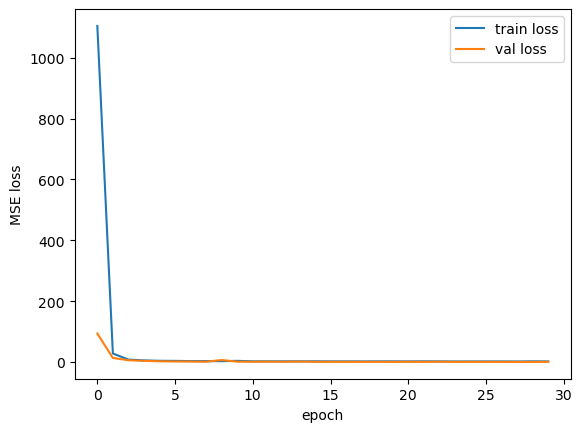

In [39]:
model = CNN().to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

X_train = torch.Tensor(train_x)
X_test = torch.Tensor(test)
y_train = torch.Tensor(train_y)
X_val = torch.Tensor(val_x)
y_val = torch.Tensor(val_y)
X_my_test = torch.Tensor(my_test_x)
y_my_test = torch.Tensor(my_test_y)

batch_size = 256
epoch_num = 30

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train(
    model,
    train_loader,
    criterion,
    optimizer,
    scheduler,
    val_loader=val_loader,
    epochs=epoch_num,
)

In [57]:
my_test_dataset = TensorDataset(X_my_test)
my_test_loader = DataLoader(my_test_dataset)
# 进行预测
predictions = []
for test_data in my_test_loader:
    td = test_data[0].to(device)
    pred = predict(model, td)
    predictions.append(pred.cpu())

In [58]:
p = torch.cat(predictions, dim=0).numpy()
# p = torch.tensor(RobustScaler().inverse_transform(p)).numpy()
print(p)

[[67.63544  66.018166]
 [66.80914  65.38296 ]
 [73.164536 82.24338 ]
 ...
 [68.09365  65.8618  ]
 [71.03061  75.38022 ]
 [67.66655  61.92884 ]]


In [59]:
mse = np.mean((my_test_y - p) ** 2)
score = calScore(mse)
print(score)

0.46613651301639525


In [60]:
X_test.shape

torch.Size([4560, 36])

In [61]:
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset)

# 进行预测
predictions = []
for test_data in test_loader:
    td = test_data[0].to(device)    
    pred = predict(model, td)
    predictions.append(pred.cpu())

In [62]:
# 将包含 PyTorch Tensor 的列表连接成一个 4560x2 的矩阵
p = torch.cat(predictions, dim=0).numpy()
# 打印矩阵的形状和第一个元素
print(p.shape)
print(p[0])

(4560, 2)
[68.6809  60.45418]


In [55]:
ans = []
for i in range(len(p)):
    s = str(t["geohash_id"].iloc[i])
    s += "\t"
    s += str(p[i][1])
    s += "\t"
    s += str(p[i][0])
    s += "\t"
    s += str(t["date_id"].iloc[i])
    ans.append(s)

df = pd.DataFrame(
    data=ans, columns=["geohash_id\tconsumption_level\tactivity_level\tdate_id"]
)
df.to_csv("output/CNN.csv", index=False)
print("finished")

finished
